In [1]:
import numpy as np
import pylab as plt
import corner
import tqdm

prm_order = ['a', 'b', 'c', 'logsig']
nprms = len(prm_order)

In [2]:
def model(x, a, b, c):
    '''The model we are fitting.'''
    return a*x**4 + b*x + c

x = np.linspace(-5, 5, 256)
SIG_N = 1
prms_true = (1.1, 2.2, 3.3)
y_meas = model(x, *prms_true) + SIG_N * np.random.normal(size=x.shape)

In [3]:
def report(prms):
    '''Generate a pretty report and plot for a set of parameters.'''
    if type(prms) == dict:
        prms = (prms['a'], prms['b'], prms['c'])
    if type(prms[0]) != float:
        prms = tuple(float(p) for p in prms)
    y = model(x, *prms)
    chisq = np.sum(np.abs(y_meas - y)**2 / SIG_N**2)
    chisq_r = chisq / (y_meas.size - len(prms))
    print(f'A:{prms[0]:7.3}, B:{prms[1]:7.3}, C:{prms[2]:7.3}')
    print(f'Chi-sq: {chisq:7.3}, Reduced Chi-sq: {chisq_r:7.3}')

    plt.figure()
    plt.plot(x, y_meas, '.', label='measured')
    plt.plot(x, y, label='model')
    plt.plot(x, y_meas - y, label='residual')
    plt.grid()
    _ = plt.legend()

A:    1.1, B:    2.2, C:    3.3
Chi-sq: 2.15e+02, Reduced Chi-sq:   0.848


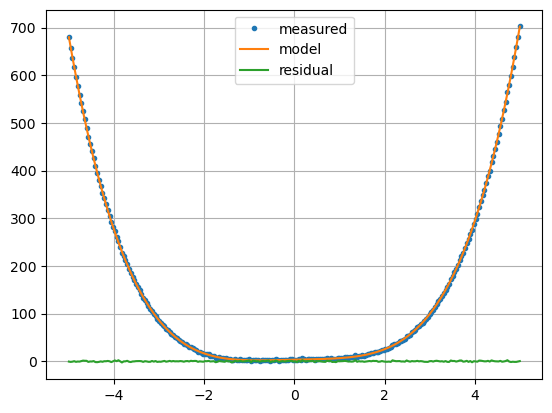

In [4]:
report(prms_true)

In [5]:
class Uniform:
    '''Model a flat (uniform) prior of a variable.'''
    def __init__(self, name, lower, upper):
        self.name = name
        self.lower = lower
        self.upper = upper
    def start_val(self):
        return np.random.uniform(self.lower, self.upper)
    def log_prior(self, val):
        if self.lower < val < self.upper:
            return 0.0
        else:
            return -np.inf
        
class Normal:
    '''Model a normal (gaussian/normal distributed) prior of a variable.'''
    def __init__(self, name, mean, sigma):
        self.name = name
        self.mean = mean
        self.sigma = sigma
    def start_val(self):
        return self.mean + self.sigma * np.random.normal()
    def log_prior(self, val):
        return -0.5*(np.log(2 * np.pi * self.sigma**2) + np.abs(val - self.mean)**2 / self.sigma**2 )

In [6]:
def log_prior(**kwargs):
    ''' evaluate the log prior from Bayes theorem'''
    return sum([prms[k].log_prior(v) for k, v in kwargs.items()])

def log_likelihood(y, yhat, sig_noise):
    ''' evaluate the log likelihood from Bayes theorem'''
    L = -0.5 * (np.log(2 * np.pi * sig_noise**2) + np.abs(y - yhat)**2 / sig_noise**2 )
    return np.sum(L)

def log_probability(prms, x, y_meas):
    ''' evaluate the log posterior from Bayes theorem'''
    a, b, c, logsig = prms
    prms = dict(zip(prm_order, prms))
    lp = log_prior(**prms)
    if not np.isfinite(lp):
        return -np.inf
    yhat = model(x, a, b, c)
    return lp + log_likelihood(y_meas, yhat, 10**logsig)

''' define priors for a,b,c, and logsig'''
prms = {
    'a': Uniform('a', lower=-5, upper=5),
    'b': Uniform('b', lower=-5, upper=5),
    'c': Uniform('c', lower=-5, upper=5),
    'logsig': Uniform('logsig', lower=-1.0, upper=1.0),
}

In [19]:
# set up a MH sampler

def _metropolis_hastings_step(current, step_size):
    ''' proposal distribution: normal propsal distribution
         takes in current step and step size'''
    proposed = current + np.random.normal(scale=step_size, size=current.size)
    acceptance_ratio = np.exp(log_probability(proposed, x, y_meas) - log_probability(current, x, y_meas))
    if np.random.uniform() < acceptance_ratio: 
        current = proposed
    return current

def metropolis_hastings(n_steps, n_burnin, step_size, prms):
    ''' run the MH chain
    for n_steps with n_burnin steps, a specified step_size, and model variable values'''
    current = np.array([prms[k].start_val() for k in prm_order])
    chain = []
    # execute burnin
    for _ in range(n_burnin - 1):
        current = _metropolis_hastings_step(current, step_size)
    # do the sampling
    for _ in tqdm.tqdm(range(n_steps)):
        current = _metropolis_hastings_step(current, step_size)
        chain.append(current)
    chain = dict(zip(prm_order, np.array(chain).T))
    return chain

chain = metropolis_hastings(12000, 10000, 0.02, prms)  # Warning!
#chain = metropolis_hastings(40000, 20000, 0.02, prms)

/tmp/ipykernel_15058/2458912036.py:7: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(log_probability(proposed, x, y_meas) - log_probability(current, x, y_meas))
100%|██████████████████████████████████| 12000/12000 [00:00<00:00, 17700.70it/s]


Text(0.5, 0, 'Step')

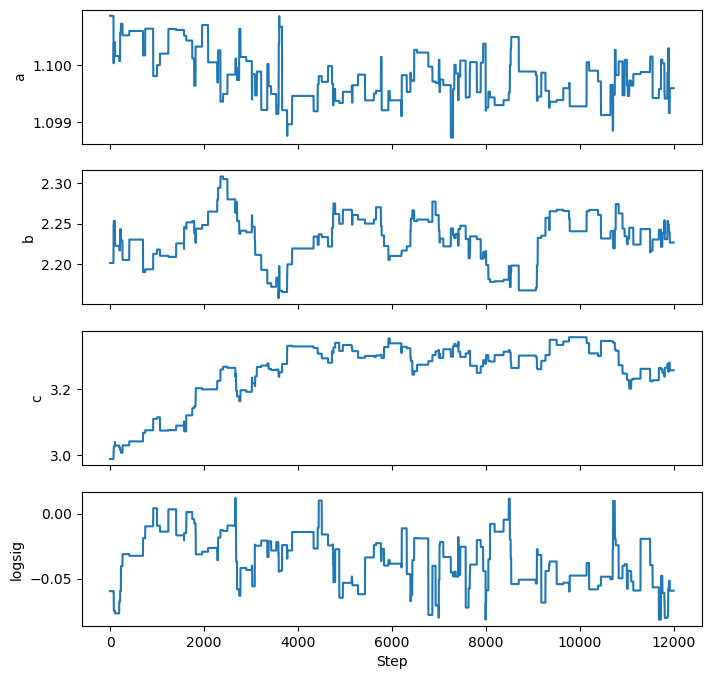

In [20]:
import pylab as plt
fig, axes = plt.subplots(nrows=nprms, sharex=True, figsize=(8,8))
for i, k in enumerate(prm_order):
    axes[i].plot(chain[k].T)
    axes[i].set_ylabel(k)
axes[nprms-1].set_xlabel('Step')

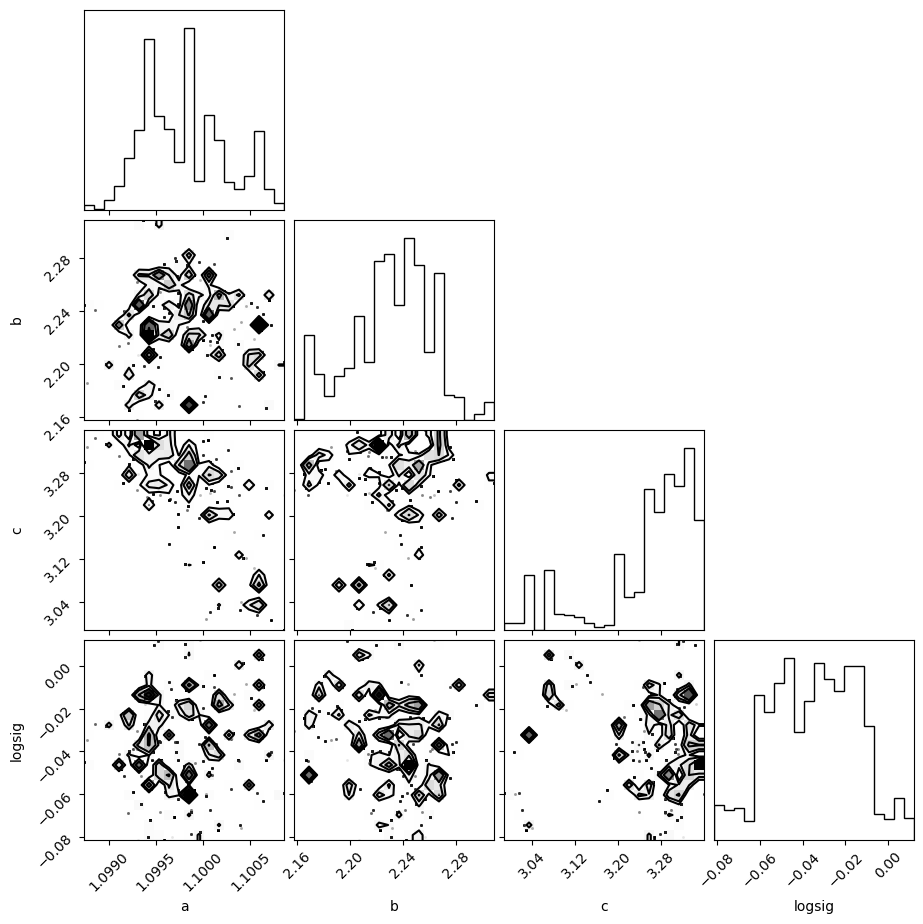

In [21]:
# make the corner plot
_ = corner.corner(chain)

Inferred noise sigma:   0.923
A:    1.1, B:   2.23, C:   3.26
Chi-sq: 2.12e+02, Reduced Chi-sq:   0.838


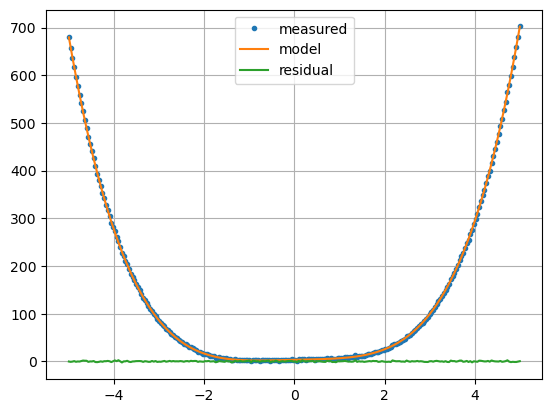

In [22]:
# do a posterior predictive check
prms_opt = {k: np.mean(chain[k]) for k in prm_order}
sig_n = 10**prms_opt.pop('logsig')
print(f'Inferred noise sigma: {sig_n:7.3}')
report(prms_opt)